# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [115]:
import pickle
import csv
import matplotlib.pyplot as plt

# Loading data
training_file = "./train.p"
validation_file= "./valid.p"
testing_file = "./test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# uploading signnames for labelling the traffic signs
sign_names = []
with open('signnames.csv') as sign:
    signname_reader = csv.DictReader(sign)
    sign_names = [row['SignName'] for row in signname_reader]

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. 
**THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### A Basic Summary of the Dataset

In [116]:
import numpy as np
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# Image data shape
image_shape = X_train[0].shape

# No. of unique classes
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of vaidation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of vaidation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory Visualization of the Dataset

The German Traffic Signs dataset is visualised in the below histogram. It is split into 43 categories of signs, with the number of images in each category on the y-axis. By looking at the histogram of the datasets, it can be observed that the distribution of the dataset is completely unequal. This is going to introduce bias into the training model, and will be addressed in the following.

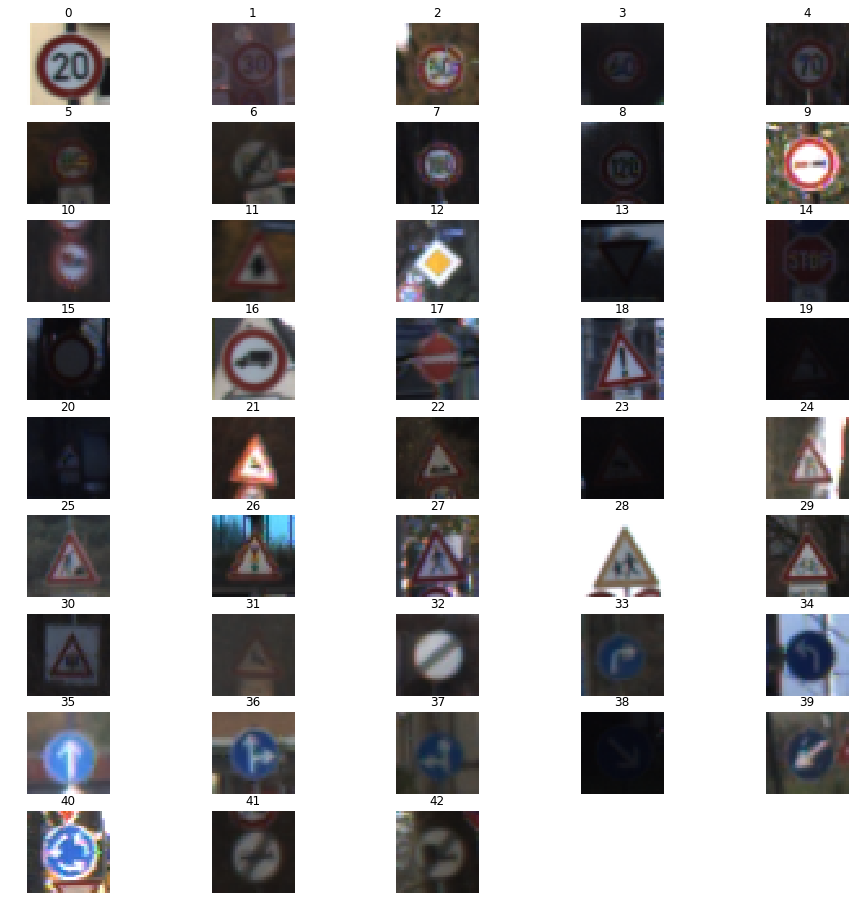

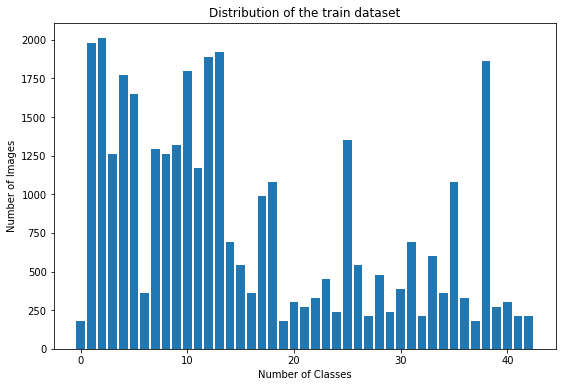

Min number of images per class = 180
Max number of Images per class = 2010


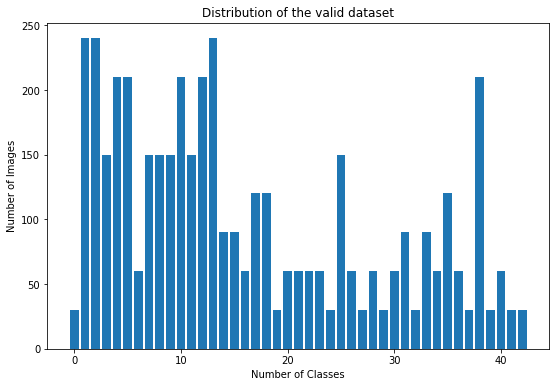

Min number of images per class = 30
Max number of images per class = 240


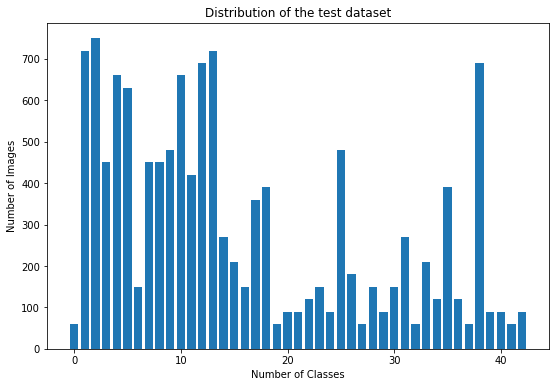

Min number of images per class = 60
Max number of images per class = 750


In [117]:
import matplotlib.pyplot as plt
%matplotlib inline

# Grabbing sign labels and unique counts of each sign type in the dataset

num_signs = []
plt.figure(figsize=(16, 16))
for i in range(0, n_classes):
    plt.subplot(9, 5, i+1)
    x_selected = X_train[y_train == i]
    plt.imshow(x_selected[0, :, :, :]) #draw the first image of each class
    plt.title(i)
    plt.axis('off')
    num_signs.append(len(x_selected))
plt.show()  

plt.figure(figsize=(9, 6))
plt.bar(range(0, n_classes), num_signs)
plt.title("Distribution of the train dataset")
plt.xlabel("Number of Classes")
plt.ylabel("Number of Images")
plt.grid
plt.show()
print("Min number of images per class =", min(num_signs))
print("Max number of Images per class =", max(num_signs))

plt.figure(figsize=(9, 6))
unique_valid, num_valid = np.unique(y_valid, return_counts=True)
plt.bar(unique_valid, num_valid)
plt.title("Distribution of the valid dataset")
plt.xlabel("Number of Classes")
plt.ylabel("Number of Images")
plt.grid
plt.show()
print("Min number of images per class =", min(num_valid))
print("Max number of images per class =", max(num_valid))

plt.figure(figsize=(9, 6))
unique_test, num_test = np.unique(y_test, return_counts=True)
plt.bar(unique_test, num_test)
plt.title("Distribution of the test dataset")
plt.xlabel("Number of Classes")
plt.ylabel("Number of Images")
plt.grid
plt.show()
print("Min number of images per class =", min(num_test))
print("Max number of images per class =", max(num_test))



### Data Preparation and Pre-processing

The steps for the process of the data to be able to train are in the following:

#### 1. Grayscaling
Grayscaling decreases the image from 3 RGB channels to a single layer, and it would be beneficial to us in terms of reducing the number of variables the network has to deal with. This improves processing times, however, loss of information because of color could is a major concern. Besides, testing with both RGB and BW images show no significant difference in performance.

#### 2. Equalization
In order to improve contrast and to provide clearer, equalization method can be used. This helps to define edges better, as well. First, OpenCV's histogram equalization was used, but it seems that the results are blurry and poor contrast. Then, Skimage's adaptive CLAHE was employed and it took longer to process the data but the results are better compared to equalization.

#### 3. Normalization
Normalization is used to scale the intensity of the image from (0, 255) to (-1, 1). 

#### 4. Augmentation (Transformation)
Due to the low number of examples for some classes, rebalancing the dataset can be utilized in order to prevent bias in the mode. Therefore, the size of th dataset is multiplied by three in all classes, including the ones already heavily represented. 

#### 5. Shuffling
The shuffling of the dataset is important step to prevent the traing of the model relies on the order of the datasets instead of the features. 


### Grayscaling, Equalisation and Normalization

In [118]:
from skimage import exposure
from sklearn.utils import shuffle
from skimage import exposure
import cv2

def Preprocess(X):
    X_norm = []  
    for image in X:
            gry = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            equ = exposure.equalize_adapthist(gry)
            equ = (equ * 2.0/equ.max())
            equ = np.reshape(equ,(32,32,1))-1
            X_norm.append(equ)
    return np.array(X_norm)

### Augmentation (Transformation)

Rotation within a certain angle and wrapping through projective transformation(skimage) are used. The reason for choosing the projective transforms is the similarity os change in camera perspective.

This link [here](http://navoshta.com/) helps me a lot to understand what I should do in this part of the project.

In [119]:
from skimage.transform import ProjectiveTransform
from skimage.transform import rotate
from skimage.transform import warp

def randomTransform(image, intensity):
    
    # Rotate image within a set range, amplified by intensity of overall transform.
    rotation = 20 * intensity
    # print(image.shape)
    rotated = rotate(image, np.random.uniform(-rotation,rotation), mode = 'edge')
    
    # Projection transform on image, amplified by intensity.
    image_size = image.shape[0]
    mag = image_size * 0.3 * intensity
    tl_top = np.random.uniform(-mag, mag)     # Top left corner, top margin
    tl_left = np.random.uniform(-mag, mag)    # Top left corner, left margin
    bl_bottom = np.random.uniform(-mag, mag)  # Bottom left corner, bottom margin
    bl_left = np.random.uniform(-mag, mag)    # Bottom left corner, left margin
    tr_top = np.random.uniform(-mag, mag)     # Top right corner, top margin
    tr_right = np.random.uniform(-mag, mag)   # Top right corner, right margin
    br_bottom = np.random.uniform(-mag, mag)  # Bottom right corner, bottom margin
    br_right = np.random.uniform(-mag, mag)   # Bottom right corner, right margin
    
    transform = ProjectiveTransform()
    transform.estimate(np.array((
            (tl_left, tl_top),
            (bl_left, image_size - bl_bottom),
            (image_size - br_right, image_size - br_bottom),
            (image_size - tr_right, tr_top))),
            np.array((
            (0, 0),
            (0, image_size),
            (image_size, image_size),
            (image_size, 0)
            )))
    transformed = warp(rotated, transform, output_shape = (image_size, image_size), order = 1, mode = 'edge')
    return transformed

def batchAugment(X, y, multiplier = 2):
    X_train_aug = []
    y_train_aug = []
    for i in range(len(X)):
        for j in range(multiplier):
            augmented = randomTransform(X[i], 0.5)
            X_train_aug.append(augmented)
            y_train_aug.append(y[i])
        X_train_aug.append(X[i])
        y_train_aug.append(y[i])
        
    X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)
    return X_train_aug, y_train_aug
    print("New augmented size is: ", len(X_train_aug))


In [139]:
###Mini pipeline of the pre-processing
######Processing both training and validation datasets
X_train_p = Preprocess(X_train)
X_valid_p = Preprocess(X_valid)

print("Pre-processing done!")

Pre-processing is done!


##### Rebalancing based on representation of classes

In [121]:
unique, counts = np.unique(y_train, return_counts=True)
print("Original distribution of classes: ", counts)
multiplier = [int(round(max(counts)/i)) for i in counts] # Required multiplier for each class augmentation.
print("Multipliers for each class: ", multiplier)
multiplier = [i-2 for i in multiplier]

X_train_aug = X_train_p
y_train_aug = y_train

for i in types:
    if multiplier[i] > 0: # Ignoring classes It is not needed for oversampling
        X_train_add = []
        y_train_add = []
        index = np.where(y_train==i)
        for j in index:
            X_train_add.append(X_train_p[j])
            y_train_add.append(y_train[j])
        X_train_add = np.array(X_train_add)
        X_train_add = np.reshape(X_train_add, (len(index[0]),32,32,1))
        y_train_add = np.array(y_train_add)
        y_train_add = np.reshape(y_train_add, (len(index[0])))
    
        print("Class: ", i+1)
        X_train_add, y_train_add = batchAugment(X_train_add, y_train_add, multiplier[i])
        X_train_aug = np.vstack((X_train_aug, X_train_add))
        print("New total dataset size: ",len(X_train_aug))
        y_train_aug = np.append(y_train_aug, y_train_add)
        print("")


unique, counts = np.unique(y_train_aug, return_counts=True)
print("New distribution of classes: ", counts)

Original distribution of classes:  [ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920  690
  540  360  990 1080  180  300  270  330  450  240 1350  540  210  480  240
  390  690  210  599  360 1080  330  180 1860  270  300  210  210]
Multipliers for each class:  [11, 1, 1, 2, 1, 1, 6, 2, 2, 2, 1, 2, 1, 1, 3, 4, 6, 2, 2, 11, 7, 7, 6, 4, 8, 1, 4, 10, 4, 8, 5, 3, 10, 3, 6, 2, 6, 11, 1, 7, 7, 10, 10]
Class:  1
New total dataset size:  36599

Class:  7
New total dataset size:  38399

Class:  15
New total dataset size:  39779

Class:  16
New total dataset size:  41399

Class:  17
New total dataset size:  43199

Class:  20
New total dataset size:  44999

Class:  21
New total dataset size:  46799

Class:  22
New total dataset size:  48419

Class:  23
New total dataset size:  50069

Class:  24
New total dataset size:  51419

Class:  25
New total dataset size:  53099

Class:  27
New total dataset size:  54719

Class:  28
New total dataset size:  56609

Class:  29
New total da

#### Histogram of the new distribution

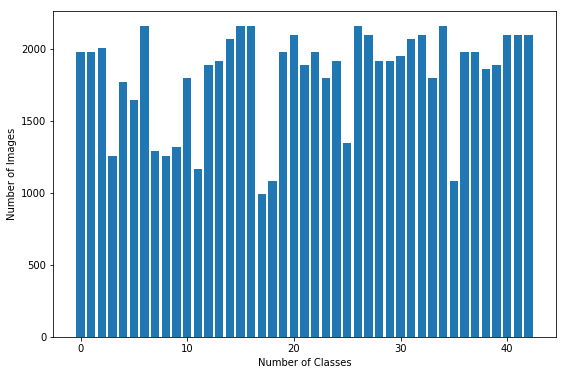

In [122]:
plt.figure(figsize=(9, 6))
plt.bar(types, counts)
plt.xlabel("Number of Classes")
plt.ylabel("Number of Images")
plt.show()

##### Multiplying the entire dataset.

In [123]:
# Triple the dataset size by rotation and transformation
X_train_aug, y_train_aug = batchAugment(X_train_aug, y_train_aug, 1)    

print("Augmentation done!")

Augmentation is done!


### Visualisation of the Pre-processing Steps

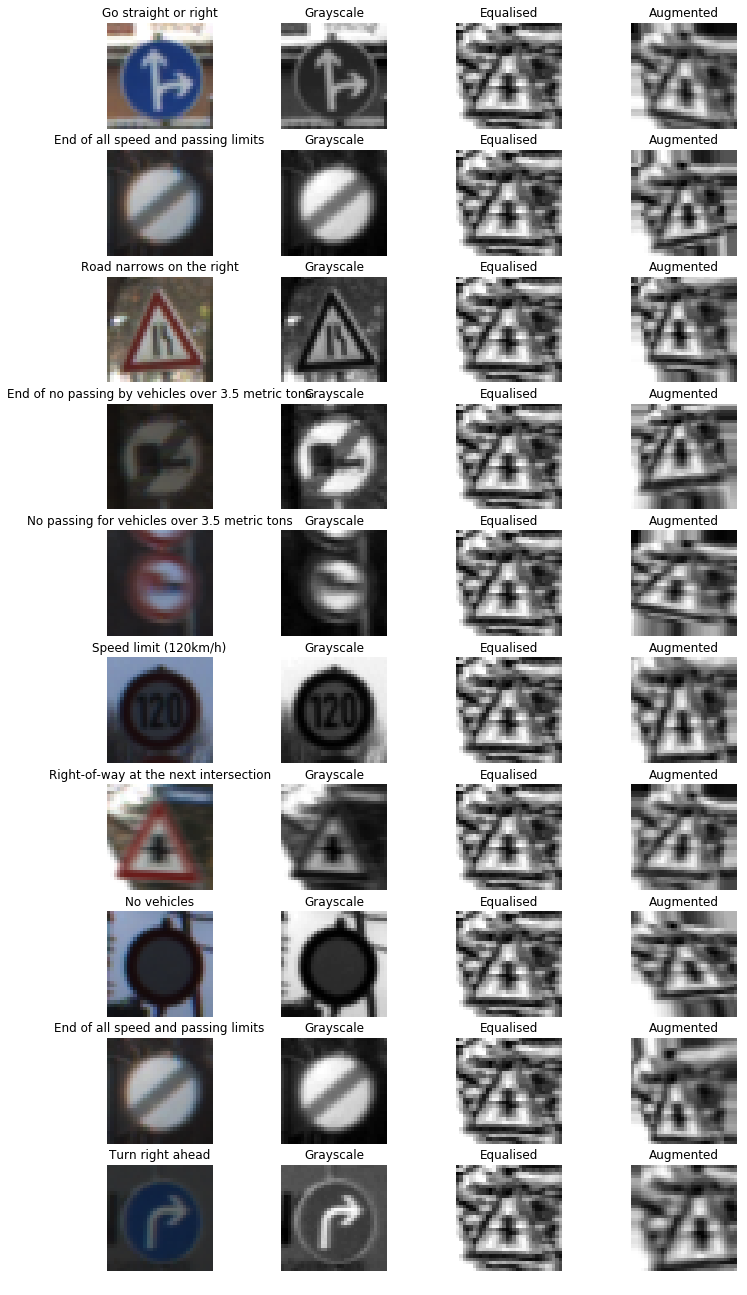

In [124]:
fig = plt.figure(figsize=(12,100))
plot = 1

for i in np.random.choice(types, 10):
    index = np.where(y_train==i)
    
    image = X_train[index[0][20]].squeeze()
    ax1 = fig.add_subplot(43,4,plot)
    ax1.set_title(sign_names[i])
    plt.axis('off')
    plt.imshow(image)
    
    gry = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ax2 = fig.add_subplot(43,4,plot+1)
    ax2.set_title('Grayscale')
    plt.axis('off')
    plt.imshow(gry, cmap='gray')
    
    equ = exposure.equalize_adapthist(bw)
    ax3 = fig.add_subplot(43,4,plot+2)
    ax3.set_title('Equalised')
    plt.axis('off')
    plt.imshow(equ, cmap='gray')
    
    proc = randomTransform(equ, 0.5)
    ax4 = fig.add_subplot(43,4,plot+3)
    ax4.set_title('Augmented')
    plt.axis('off')
    plt.imshow(proc, cmap='gray')
    
    plot += 4
    

## Model Architecture and Testing

In this step, the LeNet-5 architecture is implemented. 

### Model Architecture

In [125]:
from tensorflow.contrib.layers import flatten
import tensorflow as tf

def conv2d(x, W, b, strides=1, padding='SAME'):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return x

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    dropout = 0.85
    n_classes = 43
    
    #weight => [filter_size_height, filter_size_width, color_channels, k_output]))
    
    weights = {
        'wc1': tf.Variable(tf.truncated_normal([5, 5, 1, 6], stddev=sigma)),
        'wc2': tf.Variable(tf.truncated_normal([5, 5, 6, 16], stddev=sigma)),
        'wd1': tf.Variable(tf.truncated_normal([400, 120], stddev=sigma)),
        'wd2': tf.Variable(tf.truncated_normal([120, 84], stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal([84, n_classes], stddev=sigma))}

    biases = {
        'bc1': tf.Variable(tf.truncated_normal([6], stddev=sigma)),
        'bc2': tf.Variable(tf.truncated_normal([16], stddev=sigma)),
        'bd1': tf.Variable(tf.truncated_normal([120], stddev=sigma)),
        'bd2': tf.Variable(tf.truncated_normal([84], stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal([n_classes], stddev=sigma))}
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # Stride for each dimension: [batch, height, width, depth]
    
    x = conv2d(x, weights['wc1'], biases['bc1'], 1, 'VALID')
    
    # Activation.
    
    x = tf.nn.relu(x)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    
    x = maxpool2d(x)

    # Layer 2: Convolutional. Output = 10x10x16.
    
    x = conv2d(x, weights['wc2'], biases['bc2'], 1, 'VALID')
    
    # Activation.
    
    x = tf.nn.relu(x)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    
    x = maxpool2d(x)
    
    # Flatten. Input = 5x5x16. Output = 400.
    
    x = tf.reshape(x, [-1, weights['wd1'].get_shape().as_list()[0]])   
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.

    x = tf.add(tf.matmul(x, weights['wd1']), biases['bd1'])

    # Activation.
    
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, dropout)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    
    x = tf.add(tf.matmul(x, weights['wd2']), biases['bd2'])
    
    # Activation.
    
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, dropout)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    x = tf.add(tf.matmul(x, weights['out']), biases['out'])
    
    return x

## Features and Labels
`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

In [126]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

### Parameters


In [127]:
EPOCHS = 20
BATCH_SIZE = 128
rate = 0.001

## Training Pipeline


In [128]:
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation

In [129]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_samples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_samples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_samples

## Model Training

In [130]:
import time

X_train_p = X_train_aug
y_train = y_train_aug

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_samples = len(X_train_p)
    validation_accuracy_figure = []
    train_accuracy_figure = []
    print("Training with {} inputs...".format(len(X_train_p)))
    print()
    for i in range(EPOCHS):
        start_time =  time.time()
        X_train_p, y_train = shuffle(X_train_p, y_train)
        for offset in range(0, num_samples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_p[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        validation_accuracy = evaluate(X_valid_p, y_valid)
        validation_accuracy_figure.append(validation_accuracy)
        train_accuracy = evaluate(X_train_p, y_train)
        train_accuracy_figure.append(test_accuracy)
        print("######################")
        print(" ")
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Time Taken = {:.2f} sec".format(time.time() - start_time))
        print()
    print("######################")

    saver.save(sess, './lenet')
    print("Model is saved!")

Training with 156414 inputs...

######################
 
EPOCH 1 ...
Validation Accuracy = 0.837
Time Taken = 11.10 sec

######################
 
EPOCH 2 ...
Validation Accuracy = 0.896
Time Taken = 10.88 sec

######################
 
EPOCH 3 ...
Validation Accuracy = 0.913
Time Taken = 10.81 sec

######################
 
EPOCH 4 ...
Validation Accuracy = 0.934
Time Taken = 10.81 sec

######################
 
EPOCH 5 ...
Validation Accuracy = 0.936
Time Taken = 10.83 sec

######################
 
EPOCH 6 ...
Validation Accuracy = 0.947
Time Taken = 12.38 sec

######################
 
EPOCH 7 ...
Validation Accuracy = 0.946
Time Taken = 10.77 sec

######################
 
EPOCH 8 ...
Validation Accuracy = 0.950
Time Taken = 10.84 sec

######################
 
EPOCH 9 ...
Validation Accuracy = 0.956
Time Taken = 10.78 sec

######################
 
EPOCH 10 ...
Validation Accuracy = 0.961
Time Taken = 10.88 sec

######################
 
EPOCH 11 ...
Validation Accuracy = 0.956
Time Taken 

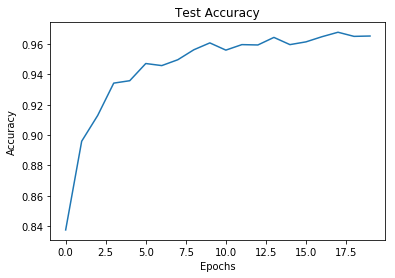

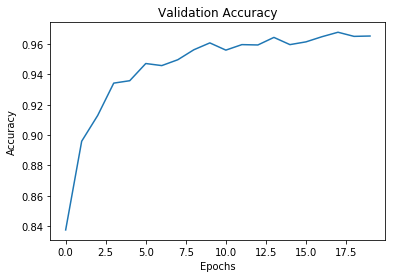

In [131]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter
import itertools

plt.plot(validation_accuracy_figure)
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid
plt.show()

plt.plot(validation_accuracy_figure)
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid
plt.show()


## Step 3: Testing Model through New Images

### Preprocess the Images

In [132]:
X_test_p = Preprocess(X_test)

### Test Accuracy
Model achieved 93% on the test dataset.

In [133]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_p, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.930


### Testing the model for five images from test dataset
The model is able to get all 5 chosen images from the test set with high accuracy. 

In [134]:
top_k_op = tf.nn.top_k(logits, 5)
sample = X_test_p[0:5]
original = X_test[0:5]

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_k_output = sess.run(top_k_op, feed_dict={x: sample})

INFO:tensorflow:Restoring parameters from ./lenet


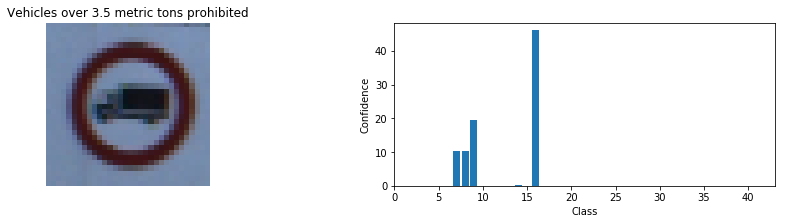

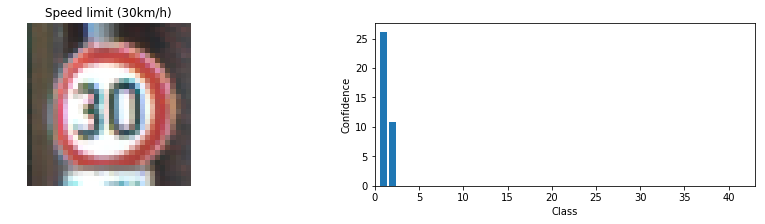

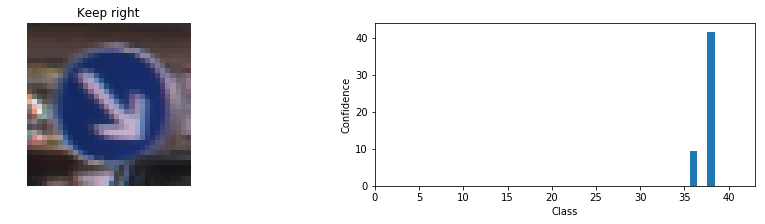

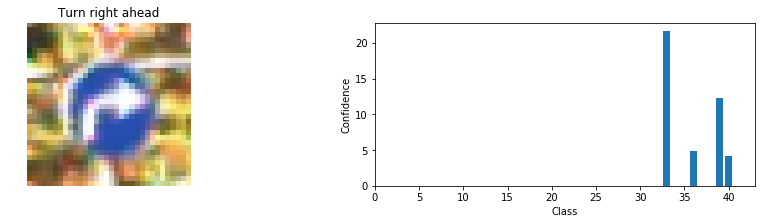

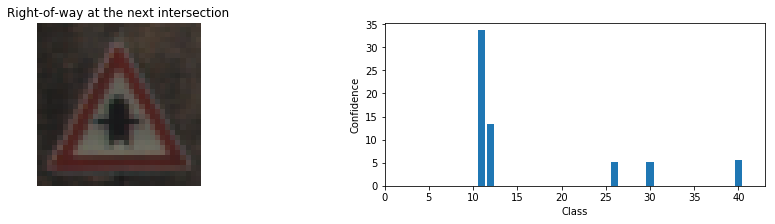

In [135]:
for i in range(len(original)):
    fig, ax = plt.subplots(1, 2, figsize=(15, 3))
    ax = ax.ravel()
    
    ax[1].bar(top_k_output.indices[i], top_k_output.values[i])
    plt.ylabel("Confidence")
    plt.xlabel("Class")
    plt.xlim([0,43])
    plt.ylim(bottom=0)
    ax[0].axis('off')
    ax[0].set_title(sign_names[y_test[i]])
    ax[0].imshow(original[i])

### Test Set Pulled From The Web

Here are six German traffic signs that I found on the web.

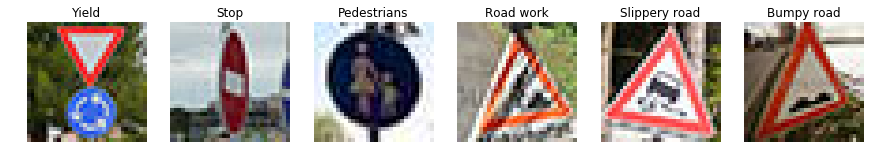

In [136]:
import glob

X_web = []
y_web = [13, 14, 27, 25, 23, 22]
for filename in glob.glob('web_images/*.jpg'): 
    im=plt.imread(filename)
    X_web.append(im)
    
fig, ax = plt.subplots(1,6, figsize=(15,10))
for i in range(len(X_web)):
    ax[i].axis('off')
    ax = ax.ravel()
    ax[i].imshow(X_web[i])
    ax[i].set_title(sign_names[y_web[i]])


Preprocessing and evaluating...

In [137]:
X_web = np.asarray(X_web)
X_web_p = Preprocess(X_web)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_web_p, y_web)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.000


INFO:tensorflow:Restoring parameters from ./lenet


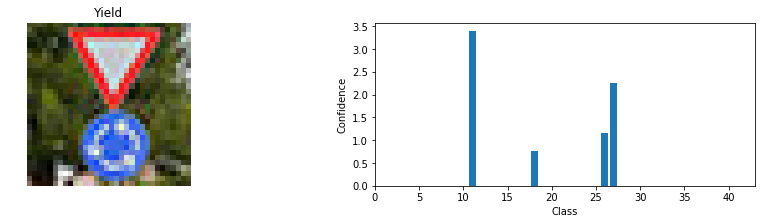

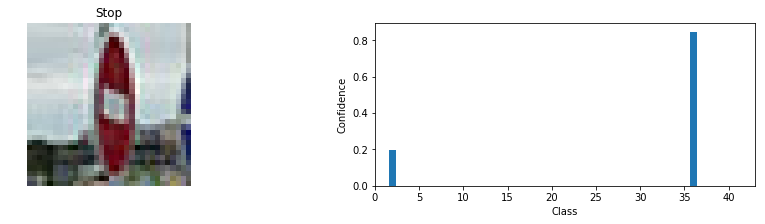

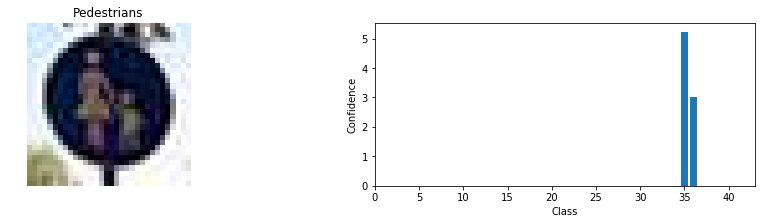

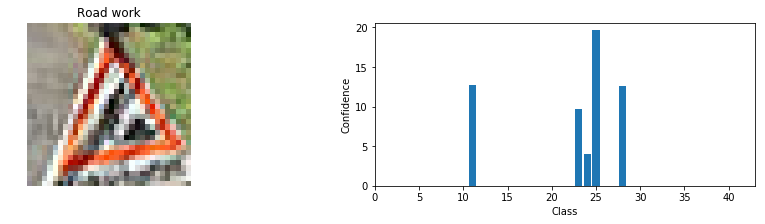

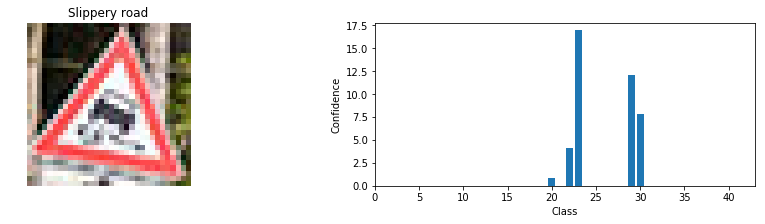

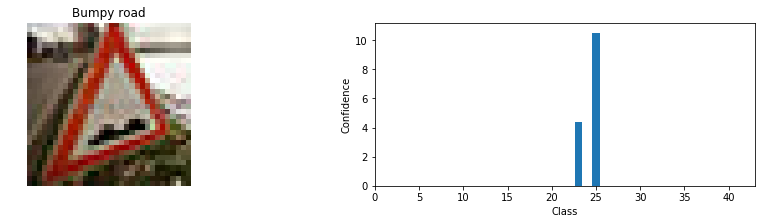

In [138]:
top_k_operation = tf.nn.top_k(logits, 5)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_k_output = sess.run(top_k_operation, feed_dict={x: X_web_p})

for i in range(len(X_web)):
    fig, ax = plt.subplots(1, 2, figsize=(15, 3))
    ax = ax.ravel()
    
    ax[1].bar(top_k_output.indices[i], top_k_output.values[i])
    plt.ylabel("Confidence")
    plt.xlabel("Class")
    plt.xlim([0,43])
    plt.ylim(bottom=0)
    ax[0].axis('off')
    ax[0].set_title(sign_names[y_web[i]])
    ax[0].imshow(X_web[i])

It seems that the model only predictr Bumpy road and Slippery road correctly. The reason could be clearaatiy of these sign compared to others.
Some steps can be taken in order to increase the performance:
1. more training on shadowed or obstructed signs
2. working on batchAugment function